In [1]:
import numpy as np
import hashlib
import math
import pandas as pd 
import matplotlib.pyplot as plt
import random
import re
import string
from nltk.tokenize import WordPunctTokenizer

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
import spacy

## Q1.

It's 2020 and every second you spend in quarantine is driving you crazy. The pandemic would already be enough, but it seems that day in, day out, people are commenting on another disaster or weird event happening around the globe. Well, at least according to twitter. 

<img src="media/biblical.png" width="50%" />


_"Maybe I shouldn't get my news from twitter..."_, you wonder.

But nah, it's too adictive. So, instead, you set your mind on trying to do a little filtering yourself and detect when  disasters are going on and people are tweeting about it. For that purpose you decide to start building a disaster detector.


After a lot of trouble extracting and classifying tweets, you come up with a dataset. 


Load the dataset and check its structure:


In [2]:
df = pd.read_csv('datasets/twitter_disaster.csv')

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
#tokenizer = WordPunctTokenizer()
#words = tokenizer.tokenize(df)
df.target.unique()

array([1, 0])

### Q1.a)

You realize, after all that you've learned in the NLP specialization, that it might be worth it to process your text a bit. 

Implement below a preprocessing function that does the following:

- tokenizes the text 
- lowercases the text 
- removes punctuation 
 

In [4]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
def preprocess_data(df):
    """Returns a dataframe with preprocessed text as a new column
    
    Parameters:
        df: input dataframe, containing a "text" column
    
    Returns:
        preprocessed_df: output dataframe, with a new column "preprocessed_text" 
    """
    
    # YOUR CODE HERE
    
    text_col = df['text'].values
    text_lower = [sentences.lower() for sentences in text_col]
    tokenizer = WordPunctTokenizer()
    words = [tokenizer.tokenize(sentences) for sentences in text_lower ]
    words_filter_all = []
    for lis1 in words:
        int_filter_lis = []
        for word in lis1:
            if word not in string.punctuation:
                int_filter_lis.append(word)
        words_filter_all.append(int_filter_lis)
    sentences = [' '.join(lis1) for lis1 in words_filter_all]
    df['preprocessed_text'] = sentences
    preprocessed_df = df.copy()

    
    #raise NotImplementedError()
    
    return preprocessed_df


In [6]:
preprocessed_df = preprocess_data(df)

assert hashlib.sha256(preprocessed_df['text'][200].encode()).hexdigest() == 'cb01387fe41613faa876fb6793179578747693d8dbfe57fd7a808376531f836f'
assert hashlib.sha256(preprocessed_df['text'][400].encode()).hexdigest() == '89869900237bf608f53e686bacb698075e76102791c7c7973dd6015730ca271c'
assert hashlib.sha256(preprocessed_df['text'][745].encode()).hexdigest() == '8ffa8f4f715c83feb96d9d8b427d90e6732e0e048e8d39b5d2694a797ed76c4e'

See how the preprocessed data looks like:

In [7]:
preprocessed_df.head()

,id,keyword,location,text,target,preprocessed_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


With your preprocessing looking nice and after spending hours just coming up with the dataset, you decide to call it a day and save your data. 

You save it in a different file (never know when you might need the raw one again) and go to sleep. 

**Note**: for further exercises you'll be using the pre-saved version of the data we provide.

### Q1.b)

In the morning you go back to your data. You start by loading your preprocessed data and split into a train and test set. 




In [8]:
df = pd.read_csv('datasets/twitter_disaster_preprocessed.csv')

df.head()

,keyword,location,text,target,preprocessed_text
0,sunk,Essex,FOOTBALL IS BACK THIS WEEKEND ITS JUST SUNK IN...,0,football is back this weekend its just sunk in...
1,mass%20murderer,NaN,White people I know you worry tirelessly about...,1,white people i know you worry tirelessly about...
2,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1,potus strategicpatience is a strategy for geno...
3,wrecked,NaN,I wrecked my stomach help,0,i wrecked my stomach help
4,curfew,urÌ£nus,It was past curfew\nand we were at the Grove,0,it was past curfew and we were at the grove


In [9]:
df.shape

(7613, 5)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.3, random_state=42)

X_train.head()

1186    Rly tragedy in MP: Some live to recount horror...
4071    I have been bleeding into this typewriter all ...
5461    @J3Lyon I'm going to put the FFVII ones out at...
5787    Womens Buckle Casual Stylish Shoulder Handbags...
7445    Vladimir Putin Issues Major Warning But Is It ...
Name: text, dtype: object

In [11]:
df.shape

(7613, 5)

You decide to move forward with some feature extraction, and go for a TFIDF tokenizer. However, you know that your space might be high-dimensional and you want to prepare for that. 

Implement a function that receives the number of desired features and returns the vectorized data together with the vectorizer and the space dimension:

In [12]:
def extract_features(X_train, X_test, feature_limit=None):
    """Converts the provided text training and test data into 
    TF-IDF feature counts. Additionally, returns the used
    vectorizer and the space dimension
    
    Parameters:
        X_train: training data
        X_test: test data
        feature_limit: maximum number of features to use

    Returns:
        vectorizer: used tf-idf vectorizer 
        num_features: vectorizer actual number of features, for sanity check
        X_train_vec: processed training features
        X_test_vec: processed test features
    """
    
    # YOUR CODE HERE
    vectorizer = TfidfVectorizer(use_idf=True,max_features=feature_limit)
    X_train_vec = vectorizer.fit_transform(X_train)
    #X_train_vec = vectorizer.transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    num_features = X_train_vec.shape[1]
    return vectorizer,num_features,X_train_vec,X_test_vec
    #raise NotImplementedError()


In [13]:
vectorizer, num_features, X_train_vec, X_test_vec = extract_features(X_train, X_test)
assert math.isclose(np.sum(X_train_vec.todense()[12, :]), 3.08383176160954)
assert num_features == 16801

vectorizer, num_features, X_train_vec, X_test_vec = extract_features(X_train, X_test, feature_limit=100)
assert math.isclose(X_train_vec.todense()[121, 12], 0.6280235685065689)
assert num_features == 100

vectorizer, num_features, X_train_vec, X_test_vec = extract_features(X_train, X_test, feature_limit=232)
assert math.isclose(np.sum(X_train_vec.todense()[300, :]), 2.906725853395745)
assert num_features == 232


In [14]:
X_train_vec.shape

(5329, 232)

### Q1.c)

Let's see what happens when we limit the number of features. What are the features the vectorizer selects?

Let's start by applying your function to obtain the vectorizer with 500 features: 

In [15]:
vectorizer, num_features, X_train_vec, X_test_vec = extract_features(X_train, X_test, feature_limit=500)

In [16]:
X_train_vec

<5329x500 sparse matrix of type '<class 'numpy.float64'>'
	with 41977 stored elements in Compressed Sparse Row format>

Now create a function to obtain the selected features of the fitted vectorizer, sorted by their inverse document frequency (in descending order). In case of tie, this is, if several features have the same IDF score, the features should be sorted by alphabetical order.

In [17]:
def get_ngrams_sorted_by_idf(fitted_vectorizer, top_features=30):
    """Returns a subset of features of a fitted TfidfVectorizer ordered by 
    their idf score
    
    Parameters:
        fitted_vectorizer (TfidfVectorizer): A fitted TfidfVectorizer
        top_features: Top features to return 
    
    Returns:
        ngrams_sorted (list): The top features of fitted_vectorizer sorted in descending order
                              by their idf score. In case of tie, the features should be sorted 
                              by alphabetical order
    """
# YOUR CODE HERE

      #vectorizer_truncated = TfidfVectorizer(ngram_range=(1,2), max_features=K)
    fitted_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=top_features)
    fitted_vectorizer_vec = fitted_vectorizer.fit_transform(X_train)
    #sum_idf = fitted_vectorizer_vec.sum(axis=0)
    lis = fitted_vectorizer.get_feature_names()
    
    #df = pd.DataFrame(sum_idf.reshape(-1,1), index=fitted_vectorizer.get_feature_names(), columns=["tfidf"]) 
    ##df = df.sort_values(by=["tfidf"],ascending=False)
    #lis_df = list(df.index.values)
    return lis
#raise NotImplementedError()


In [18]:
fitted_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500)
fitted_vectorizer_vec = fitted_vectorizer.fit_transform(X_train)
sum_idf = fitted_vectorizer_vec.sum(axis=0)
    
df = pd.DataFrame(sum_idf.reshape(-1,1), index=fitted_vectorizer.get_feature_names(), columns=["tfidf"]) 
df = df.sort_values(by=["tfidf"],ascending=False)
lis_df = list(df.index.values)
x = list(df.tfidf.values)


In [19]:
ddf = get_ngrams_sorted_by_idf(vectorizer, top_features=100)


In [20]:
get_ngrams_sorted_by_idf(vectorizer, top_features=100)[12]

'body'

In [21]:
assert hashlib.sha256(get_ngrams_sorted_by_idf(vectorizer, top_features=100)[12].encode()).hexdigest() == "aacd834b5cdc64a329e27649143406dd068306542988dfc250d6184745894849"
assert hashlib.sha256(get_ngrams_sorted_by_idf(vectorizer, top_features=100)[41].encode()).hexdigest() == "9e96274abcf3df0dfcd14617d6a14931c97fca364083918e38f8cfd20d136f0d"


AssertionError: 

Check the features with top inverse document frequency in your vectorizer:

In [ ]:
#show most specifc 30 features of the 100 selected features
get_ngrams_sorted_by_idf(vectorizer, top_features=30)

### Q1.d)

Not bad, but you remember learning about Chi squared,  method that will select features by relevance and you decide to compare how effective it is. 


In [ ]:
def extract_features_chi2(X_train, X_test, y_train, feature_limit=100):
    """Converts the provided text training and test data into 
    TF-IDF feature counts. Additionally, selects the best features
    with chi squared method. Finally, it returns the used
    vectorizer and the feature selector
    
    Parameters:
        X_train: training data
        X_test: test data
        y_train: training labels
        feature_limit: maximum number of features to use

    Returns:
        vectorizer: used tf-idf vectorizer 
        ch2: used feature selector
        X_train_ch2: processed training features
        X_test_ch2: processed test features
    """
    
    # YOUR CODE HERE
    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_train)
    X_train_vec = vectorizer.transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    ch2 = SelectKBest(chi2, k=feature_limit)
    ch2.fit(X_train_vec,y_train)
    X_train_ch2 = ch2.transform(X_train_vec)
    X_test_ch2 = ch2.transform(X_test_vec)
    #most_important_features = [feature_names[i] for i in ch2.get_support(indices=True)]
    return vectorizer,ch2,X_train_ch2,X_test_ch2
    #raise NotImplementedError()

In [ ]:
vectorizer_ch2, ch2, X_train_ch2, X_test_ch2 = extract_features_chi2(X_train, X_test, y_train)
assert math.isclose(np.sum(X_train_ch2.todense()[12, :]), 0.15232491597861014)
assert ch2.k == 100

vectorizer_ch2, ch2, X_train_ch2, X_test_ch2 = extract_features_chi2(X_train, X_test, y_train, feature_limit=123)
assert math.isclose(np.sum(X_train_ch2.todense()[:, 122]), 36.32984514344287)
assert ch2.k == 123

vectorizer_ch2, ch2, X_train_ch2, X_test_ch2 = extract_features_chi2(X_train, X_test, y_train, feature_limit=232)
assert math.isclose(np.sum(X_train_ch2.todense()[300, :]), 1.1419313656030479)
assert ch2.k == 232

In [ ]:
np.sum(X_train_ch2.todense()[12, :])

Once again, apply the extractor to our data and check the top relevant features

In [ ]:
vectorizer_ch2, ch2, X_train_ch2, X_test_ch2 = extract_features_chi2(X_train, X_test, y_train, feature_limit=30)

Now create a function similar to the one before to get the selected features ordered

In [ ]:
def get_chi2_ngrams_sorted(fitted_vectorizer, fitted_ch2_selector):
    """Returns the selected features (ngrams) given a vectorizer and 
    chi-squared selector
    
    Parameters:
        fitted_vectorizer (TfidfVectorizer): A fitted TfidfVectorizer
        fitted_ch2_selector (SelectKBest): A fitted chi squared selector 
    
    Returns:
        ngrams_sorted (list): The top features of fitted_vectorizer sorted in ascending order
                              by their idf score
    """
    # YOUR CODE HERE
    fitted_vectorizer.fit(X_train)
    X_train_vec = fitted_vectorizer.transform(X_train)
    X_test_vec = fitted_vectorizer.transform(X_test)
    #ch2 = SelectKBest(chi2, k=feature_limit)
    fitted_ch2_selector.fit(X_train_vec,y_train)
    X_train_ch2 = fitted_ch2_selector.transform(X_train_vec)
    feature_names = fitted_vectorizer.get_feature_names()
    most_important_features = [feature_names[i] for i in fitted_ch2_selector.get_support(indices=True)]
    return most_important_features
    #raise NotImplementedError()


Finally, check the features selected by chi squared:

In [ ]:
most_important_features = get_chi2_ngrams_sorted(vectorizer_ch2, ch2)

most_important_features

We can see how often each of the features selected appears in the tweets:

In [ ]:
for feature in most_important_features:
    print('Documents that contains the word(s) "%s"' % feature)
    print('----')
    docs = X_train.str.lower().str.contains(feature)
    print(str(y_train[docs].value_counts()) + '\n\n')

It should be visible that most features selected are linked to the "disaster" class (1).

## Q2.

### Time for some modelling

You finally decide to put everything together and get your first baseline. 

First of all, you figure you should use precision and recall to measure your models performance. Even though our data is not inbalanced it can give you more granularity over your target class - predicting a tweet is about disaster - even if a few tweets of the other class get mislabeled.

Implement a function to compute precision and recall given your predictions and true labels:


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def get_precision_recall(y_test, y_pred):
    """Returns the precision and recall of the disaster class (label = 1)
    
    Parameters:
        y_test (Series): Labels corresponding to X_test
        y_pred (Series): Predictions corresponding to X_test

    Returns:
        precision (float): The precision score of the disaster class (1) on the test data
        recall (float): The recall score of the disaster class (1) on the test data
    """

    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    return precision,recall
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    


In [ ]:
np.random.seed(42)
precision, recall = get_precision_recall(pd.Series(np.random.choice([0, 1], size=30)), pd.Series(np.random.choice([0, 1], size=30)))
assert precision == 0.4
assert recall == 0.375

vectorizer, np.random.seed(30)
precision, recall = get_precision_recall(pd.Series(np.random.choice([0, 1], size=30)), pd.Series(np.random.choice([0, 1], size=30)))
assert precision == 0.45
assert recall == 0.5294117647058824

vectorizer, np.random.seed(12)
precision, recall = get_precision_recall(pd.Series(np.random.choice([0, 1], size=30)), pd.Series(np.random.choice([0, 1], size=30)))
assert precision == 0.6
assert recall == 0.6


Now that your metrics are ready, you jump to the model. 

As stopwords appeared in the list of features also, you decide to provide an option to remove stop words.

Write up a function that receives the train and test data, vectorizes it, selects a given number of features with chi-squared, and finally trains a multinomial Naive Bayes model to classify the tweets. Expose your predictions precision and recall.

In [ ]:
def train_model_chi2_naive_bayes(X_train, y_train, X_test, y_test, max_features=100, stopwords=None):
    """Returns a fitted TfidfVectorizer, the chi squared selector, a naive bayes classifier
    and the test predictions computed with these
    
    Parameters:
        X_train (Series): Text data for training
        y_train (Series): Labels corresponding to X_train
        X_test (Series): Text data for testing
        y_test (Series): Labels corresponding to X_test
        max_features (int): maximum number of features to use
        stopwords (str): stopwords to use (if None does not use stopwords). eg 'english'

    Returns:
        vectorizer (TfidfVectorizer): TfidfVectorizer, fitted to X_train
        ch2 (SelectKBest): SelectKBest with score function chi2 and provided number of features, 
                           fitted to vectorized X_train
        clf (MultinomialNB): MultinomialNB classifier fitted to the feature-selected training data
        y_pred (Series): The predictions computed with our classifier
    """
    
    # YOUR CODE HERE
    vectorizer = TfidfVectorizer(stop_words=stopwords)
    vectorizer.fit(X_train)
    X_train_vec = vectorizer.transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    ch2 = SelectKBest(chi2, k=max_features)
    ch2.fit(X_train_vec,y_train)
    X_train_chi2 = ch2.transform(X_train_vec)
    X_test_chi2 = ch2.transform(X_test_vec)
    clf = MultinomialNB()
    clf.fit(X_train_chi2,y_train)
    y_pred = clf.predict(X_test_chi2)
    #raise NotImplementedError()
    
    return vectorizer, ch2, clf, y_pred

In [ ]:
vectorizer, ch2, clf, y_pred_200 = \
    train_model_chi2_naive_bayes(X_train, y_train, X_test, y_test, max_features=200, stopwords="english")

In [ ]:
np.mean(y_pred_200)

In [ ]:
vectorizer, ch2, clf, y_pred_200 = \
    train_model_chi2_naive_bayes(X_train, y_train, X_test, y_test, max_features=200, stopwords="english")
assert np.mean(y_pred_200) == 0.17075306479859895
assert np.sum(y_pred_200) == 390
assert ch2.k == 200
assert vectorizer.get_feature_names()[7424] == 'independence'


vectorizer, ch2, clf, y_pred_500 = \
    train_model_chi2_naive_bayes(X_train, y_train, X_test, y_test, max_features=500, stopwords="english")
assert np.mean(y_pred_500) == 0.2591943957968476
assert np.sum(y_pred_500) == 592
assert ch2.k == 500
assert vectorizer.get_feature_names()[7424] == 'independence'


vectorizer, ch2, clf, y_pred_1000 = \
    train_model_chi2_naive_bayes(X_train, y_train, X_test, y_test, max_features=1000, stopwords="english")
assert np.mean(y_pred_1000) == 0.3021015761821366
assert np.sum(y_pred_1000) == 690
assert ch2.k == 1000
assert vectorizer.get_feature_names()[7424] == 'independence'


Now apply your previous precision and recall function to check the metrics of each prediction:

In [ ]:
precision, recall = get_precision_recall(y_test, y_pred_200)     
print("\nPredictions with 200 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

precision, recall = get_precision_recall(y_test, y_pred_500)      
print("\nPredictions with 500 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

precision, recall = get_precision_recall(y_test, y_pred_1000)     
print("\nPredictions with 1000 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))


It seems we have a high precision but a low recall for predicting a disaster. But as you see, as we increase the number of features used we are sacrificing the precision and gaining on recall, probably widening the range of tweets we are classifying as a disaster. 

This makes sense given that most of the top selected features are linked to the disaster class.


## Q3.

You are pretty happy with your baseline but you're still using a pretty number of features to get a good precision/recall ratio. You now decide to move on to other techniques, such as SVD and PCA.


Start by writting up a similar function to the previous one to train your model, but use SVD and classify your model with Support Vector Classification.

In [ ]:
def train_model_svd_svm(X_train, y_train, X_test, y_test, num_features=100, seed=42):
    """Returns a fitted TfidfVectorizer, the truncated svd used, a support vector classifier
    and the test predictions computed with these
    
    Parameters:
        X_train (Series): Text data for training
        y_train (Series): Labels corresponding to X_train
        X_test (Series): Text data for testing
        y_test (Series): Labels corresponding to X_test
        num_features (int): maximum number of features to use
        seed (int): Seed to use for random state

    Returns:
        vectorizer (TfidfVectorizer): TfidfVectorizer, fitted to X_train
        svd (TruncatedSVD): TruncatedSVD with provided number of features as components
        clf (SVC): SVC classifier fitted to the feature-selected training data
        y_pred (Series): The predictions computed with our classifier
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_train)
    X_train_vec = vectorizer.transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    svd = TruncatedSVD(n_components=num_features, random_state=seed)
    svd.fit(X_train_vec)
    X_train_svd = svd.transform(X_train_vec)
    X_test_svd =  svd.transform(X_test_vec)
    #print('\nVariance:')
    #print(np.var(X_train_svd, axis=0).sum())
    #true_variance.append(1.0*np.var(X_train_svd, axis=0).sum() / data_var)
    #explained_variance.append(svd.explained_variance_)
    
    clf =  SVC()
    clf.fit(X_train_svd, y_train)
    y_pred = clf.predict(X_test_svd)
    
    
    return vectorizer, svd, clf, y_pred

In [ ]:
vectorizer, svd, clf, y_pred_30 = train_model_svd_svm(X_train, y_train, X_test, y_test, num_features=30, seed=42)
print("----- Computed for 30 features -----\n")
assert np.mean(y_pred_30) == 0.30122591943957966
assert np.sum(y_pred_30) == 688
assert svd.n_components == 30
assert vectorizer.get_feature_names()[5424] == 'exploit'


vectorizer, svd, clf, y_pred_50 = train_model_svd_svm(X_train, y_train, X_test, y_test, num_features=50, seed=42)
print("----- Computed for 50 features -----\n")
assert np.mean(y_pred_50) == 0.3261821366024518
assert np.sum(y_pred_50) == 745
assert svd.n_components == 50
assert vectorizer.get_feature_names()[5424] == 'exploit'

vectorizer, svd, clf, y_pred_100 = train_model_svd_svm(X_train, y_train, X_test, y_test, num_features=100, seed=42)
print("----- Computed for 100 features -----\n")
assert np.mean(y_pred_100) == 0.3445709281961471
assert np.sum(y_pred_100) == 787
assert svd.n_components == 100
assert vectorizer.get_feature_names()[5424] == 'exploit'

We can obtain the precision and recall as before and compare with the previous results:

In [ ]:
precision, recall = get_precision_recall(y_test, y_pred_30)     
print("\nPredictions with 30 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

precision, recall = get_precision_recall(y_test, y_pred_50)      
print("\nPredictions with 50 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

precision, recall = get_precision_recall(y_test, y_pred_100)     
print("\nPredictions with 100 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

## Q4.

With much less features we get a better recall and only slightly lower precision, nice! Remember now some of the pros and cons of SVD and other dimensionality reduction techniques. While SVD performed better, likely because in theory it can capture information from more than 50 ngrams (whereas in chi-squared the number of features was in a direct correspondence with the number of ngrams), with SVD we lose interpretability and can't examine the most important features!

Now let's try PCA.

Write a similar function to Q3 but now using PCA to see how it compares to SVD

In [ ]:
def train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=100, seed=42):
    """Returns a fitted TfidfVectorizer, the truncated svd used, a support vector classifier
    and the test predictions computed with these
    
    Parameters:
        X_train (Series): Text data for training
        y_train (Series): Labels corresponding to X_train
        X_test (Series): Text data for testing
        y_test (Series): Labels corresponding to X_test
        num_features (int): maximum number of features to use
        seed (int): Seed to use for random state

    Returns:
        vectorizer (TfidfVectorizer): TfidfVectorizer, fitted to X_train
        pca (PCA): PCA with provided number of features as components
        clf (SVC): SVC classifier fitted to the feature-selected training data
        y_pred (Series): The predictions computed with our classifier
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_train)
    X_train_vec = vectorizer.transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    dense_X_train = X_train_vec.toarray()
    dense_X_test = X_test_vec.toarray()
    pca = PCA(n_components=num_features, random_state=seed)
    pca.fit(dense_X_train)
    X_train_pca = pca.transform(dense_X_train)
    X_test_pca =  pca.transform(dense_X_test)
    
    clf =  SVC()
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    
    
    return vectorizer, pca, clf, y_pred

In [ ]:
vectorizer, pca, clf, y_pred_30 = train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=30, seed=42)
print("----- Computed for 30 features -----\n")
assert np.mean(y_pred_30) == 0.30035026269702275
assert np.sum(y_pred_30) == 686
assert pca.n_components == 30
assert vectorizer.get_feature_names()[5424] == 'exploit'

vectorizer, pca, clf, y_pred_50 = train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=50, seed=42)
print("----- Computed for 50 features -----\n")
assert np.mean(y_pred_50) == 0.3126094570928196
assert np.sum(y_pred_50) == 714
assert pca.n_components == 50
assert vectorizer.get_feature_names()[5424] == 'exploit'

vectorizer, pca, clf, y_pred_100 = train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=100, seed=42)
print("----- Computed for 100 features -----\n")
assert np.mean(y_pred_100) == 0.33887915936952717
assert np.sum(y_pred_100) == 774
assert pca.n_components == 100
assert vectorizer.get_feature_names()[5424] == 'exploit'

We can obtain the precision and recall as before and compare with the previous results:

In [ ]:
precision, recall = get_precision_recall(y_test, y_pred_30)     
print("\nPredictions with 30 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

precision, recall = get_precision_recall(y_test, y_pred_50)      
print("\nPredictions with 50 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

precision, recall = get_precision_recall(y_test, y_pred_100)     
print("\nPredictions with 100 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

## Q5.

Now we'll change gears a bit and look into word vectors. In Learning Notebook 3 we told you that word vectors can be visualized after being projected into 2D space, and we showed you this diagram:

<img src="./media/word-vectors-projection.png" width="600">

Now we'll try to combine what you've learned about word embeddings and PCA to make our own visualization!

In [26]:
# load word embeddings

nlp = spacy.load('en_core_web_md')

### Q5.a)

First, to get comfortable with spacy, get the vector for the word "disaster" 

In [30]:
disaster_vector = nlp('disaster').vector

# YOUR CODE HERE
#raise NotImplementedError()

In [31]:
assert math.isclose(disaster_vector.sum(), -6.004221, abs_tol=0.00001)
assert disaster_vector.shape[0] == 300

### Q5.b) 

Next, write a function that uses sklearn's PCA to reduce our vectors to a convenient number of dimensions for plotting. The function should return the reduced dimension word vectors.

In [65]:
def reduce_word_vecs(vectors, random_state):
    """
    Returns PCA-reduced word vectors of the input vectors for plotting
    
    Parameters:
        vectors (np.array): Word vectors to be reduced
        random_state (int): random state to use in PCA

    Returns:
        reduced_vecs (np.array): Word vectors reduced to the number of dimensions
                                 suitable for plotting with given random_state
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    #n_components = vectores.shape[1]
    pca = PCA(n_components=min(vectors.shape[0], vectors.shape[1])-1,random_state=random_state)
    pca.fit(vectors)
    reduced_vecs = pca.transform(vectors)
    
    return reduced_vecs

In [68]:
test_vectors = np.array([[0.1, 0.2, 0.3, 0.4], [0.3, 0.5, 0.1, 0.7], [0.8, 0.6, 0.2, 0.4]])
reduced_vecs = reduce_word_vecs(test_vectors, random_state=42)

assert reduced_vecs.shape == (3,2)
assert math.isclose(reduced_vecs[1][1], 0.24736592153367926)
assert math.isclose(reduced_vecs[2][0], 0.43388622222454437)

Now, we'll create an array of ~75,000 of spacy's word vectors and use your PCA function to reduce them. If you're curious about using the full amount of word vectors, you can change the code to iterate over all vocab words - `list(nlp.vocab.strings)` - instead of our own `vocab_strings`, but beware it will use a lot of memory!

We'll also set a list of words that we'll plot later and force our set of vectors to include these.

In [70]:
words_to_plot = ['banana', 'pineapple', 'mango', 'red', 'blue', 'yellow', 'woman', 'man', 'child', 'playing',
                 'reading', 'studying', 'nintendo', 'sony', 'xbox', 'sad', 'angry', 'bored']

In [71]:
with open('datasets/word_subset.txt') as fwords:
    vocab_strings = fwords.read().splitlines()

full_vocab_vecs = []
for tok in vocab_strings:
    full_vocab_vecs.append(nlp.vocab.get_vector(tok))

vocab_array = np.array(full_vocab_vecs)

In [72]:
print('Word vectors shape pre-PCA: {}'.format(vocab_array.shape))

full_vocab_reduced = reduce_word_vecs(vocab_array, random_state=42)

print('Word vectors shape after PCA: {}'.format(full_vocab_reduced.shape))

Word vectors shape pre-PCA: (103202, 300)
Word vectors shape after PCA: (103202, 299)


In [73]:
assert math.isclose(full_vocab_reduced[100][0], -3.0880196, abs_tol=0.00001)
assert math.isclose(full_vocab_reduced[9999][0], -0.9480563, abs_tol=0.00001)

### Q5.c)

Time to plot! For this, we'll limit the visualized words to a small subset.

In [74]:
coords = []
for word in words_to_plot:
    idx = vocab_strings.index(word)
    coords.append(full_vocab_reduced[idx])

coords_array = np.array(coords)

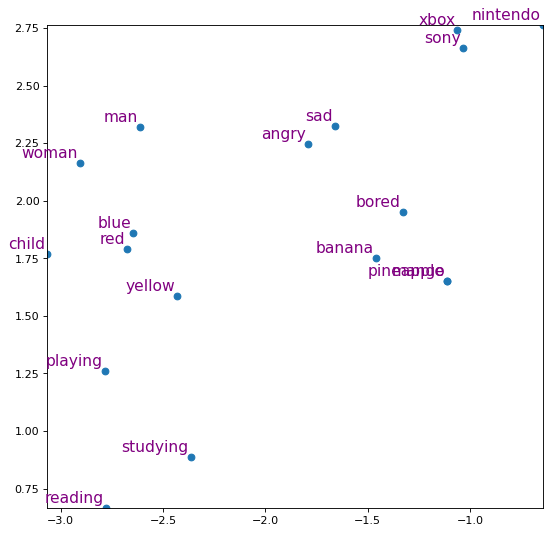

In [75]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

plt.xlim(min([x for x in coords_array[:,0]]), max([x for x in coords_array[:,0]]))
plt.ylim(min([y for y in coords_array[:,1]]), max([y for y in coords_array[:,1]]))
plt.scatter(coords_array[:,0], coords_array[:,1])

for item, x, y in zip(words_to_plot, coords_array[:,0], coords_array[:,1]):
    plt.annotate(item, xy=(x, y), xytext=(-2, 2), textcoords='offset points', 
                 ha='right', va='bottom', color='purple', fontsize=14 )
plt.show()

The PCA seems to have worked! In the diagram we can see similar types of words closer together. But of course, take these visualizations with a grain of salt because it is practically impossible to preserve all distances in a high dimensional space in just 2 dimensions.

### Q5.d) 

As a final exercise, we'll look at some word similarities.

Write a function that returns the next closest word in terms of cosine similarity to a given word. If there are multiple words with the same highest similarity, return all of them.

Hint: you can use the already-imported `cosine_similarity` function from sklearn to compute cosine similarity.

In [76]:
def closest_word(input_word, words_in_vocab, word_vectors):
    '''Returns a list of the closest word or words to the input word, based on cosine similarities
       of the word vectors given
    
    Parameters:
        input_word (string): Search for the closest words to this word
        words_in_vocab (list): Vocabulary associated with the vectors in word_vectors
        word_vectors (np.array): Word vectors associated with the strings in words_in_vocab

    Returns:
        closest_words_list (list): List of strings containing the closest word or words to
                                   input_word, based on cosine similarities of the word_vectors
    '''
    # YOUR CODE HERE
    vector_input_word = nlp(input_word).vector
    for index in range(len(word_vectors)):
        cs = cosine_similarity(vector_input_word,word_vectors[index])
        
   # raise NotImplementedError()
    #return closest_words_list
    return cs

In [81]:
coords_array.shape

(18, 299)

In [83]:
words_to_plot

['banana',
 'pineapple',
 'mango',
 'red',
 'blue',
 'yellow',
 'woman',
 'man',
 'child',
 'playing',
 'reading',
 'studying',
 'nintendo',
 'sony',
 'xbox',
 'sad',
 'angry',
 'bored']

In [ ]:
assert(hashlib.sha256(closest_word('nintendo', words_to_plot, coords_array)[0].encode()).hexdigest() == "f711da60664c04c146d7a47b722c38a8d0bf46c3f52c2084c5c8d1cb78138e73")
assert(hashlib.sha256(closest_word('playing', words_to_plot, coords_array)[0].encode()).hexdigest() == "435c149cbc6a5e5cc373cd33347d4c336a22160e06b7df61092b66e56f4d55ec")
assert(hashlib.sha256(closest_word('pineapple', words_to_plot, coords_array)[0].encode()).hexdigest() == "6815f3c300383519de8e437497e2c3e97852fe8d717a5419d5aafb00cb43c494")

In [ ]:
print("\nClosest words to nintendo:")
print(closest_word('nintendo', words_to_plot, coords_array))

print("\nClosest words to playing:")
print(closest_word('playing', words_to_plot, coords_array))

print("\nClosest words to pineapple:")
print(closest_word('pineapple', words_to_plot, coords_array))